# SMS Spam Tespiti | NLP Classification

Kısa mesaj (SMS) içeriklerini **spam / ham** olarak sınıflandıran NLP modeli. TF-IDF tabanlı geleneksel makine öğrenmesi ve Embedding tabanlı derin öğrenme yaklaşımları karşılaştırılmaktadır.

| Özellik | Detay |
|---------|-------|
| **Veri Seti** | spam.csv — 5.572 mesaj (ham: 4.825, spam: 747) |
| **Problem Türü** | İkili Sınıflandırma (NLP) |
| **Hedef Değişken** | `class` — spam (1) / ham (0) |
| **En İyi ML Modeli** | SVM + TF-IDF (n-gram) — Accuracy: 97.94% |
| **DL Modeli** | Embedding + GAP + Dense — Accuracy: 97.22% |
| **Pipeline** | TfidfVectorizer (ngram 1-2) → SVC (linear) |

**İş Akışı:** Veri Yükleme → Metin Temizleme → TF-IDF → SVM → Embedding DL Modeli → Karşılaştırma → Kayıt

In [1]:
# Temel Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Makine Öğrenmesi
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import joblib

print('✅ Kütüphaneler yüklendi.')

✅ Kütüphaneler yüklendi.


## 📊 1. Veri Yükleme ve İlk İnceleme

In [2]:
try:
    df = pd.read_csv('spam.csv', encoding='latin1', low_memory=False)
    print(f"✅ Veri Seti Yüklendi. Boyut: {df.shape}")
except Exception as e:
    print(f"❌ Hata: {e}")

display(df.head())
display(df.tail())
display(df.sample(5))

print(df.info())
print(df.describe().T)
print(f"Sütunlar: {df.columns.tolist()}")
print(df.isnull().sum()[df.isnull().sum() > 0])

✅ Veri Seti Yüklendi. Boyut: (5572, 5)


,class,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


,class,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


,class,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
2449,ham,Then she dun believe wat?,NaN,NaN,NaN
5496,ham,Yes... I trust u to buy new stuff ASAP so I ca...,NaN,NaN,NaN
5188,ham,Okie,NaN,NaN,NaN
1414,ham,So wats ur opinion abt him and how abt is char...,NaN,NaN,NaN
908,ham,WHITE FUDGE OREOS ARE IN STORES,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class       5572 non-null   object
 1   message     5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None
           count unique                                                top  \
class       5572      2                                                ham   
message     5572   5169                             Sorry, I'll call later   
Unnamed: 2    50     43   bt not his girlfrnd... G o o d n i g h t . . .@"   
Unnamed: 3    12     10                               MK17 92H. 450Ppw 16"   
Unnamed: 4     6      5                                            GNT:-)"   

            freq  
class       4825  
message       30  
Unnamed: 2     3  
Unnamed: 3     2  
Unn

In [3]:
df=df.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"],axis=1)

In [4]:
df.isnull().sum()

class      0
message    0
dtype: int64

In [11]:
"""
x = np.array(df["message"])
y = np.array(df["class"])

cv = CountVectorizer()
X = cv.fit_transform(x) # Fit the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train,y_train)
"""

# Prepare Data
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['class'].map({'spam': 1, 'ham': 0}), test_size=0.2, random_state=42)

# SVM Pipeline with TF-IDF
# ngram_range=(1, 2) helps capture context like 'std chgs'
ml_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=10000)),
    ('classifier', SVC(kernel='linear', probability=True))
])

ml_pipeline.fit(X_train, y_train)
print(f'ML Model Accuracy: {ml_pipeline.score(X_test, y_test):.4f}')

ML Model Accuracy: 0.9794


In [12]:
sample = input('Enter a message:')
print(ml_pipeline.predict([sample]))

Enter a message: zbbzfngnzgfnjgfzzns


[0]


# 🧠 Deep Learning Approach

In [13]:
"""
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, TextVectorization, Embedding, GlobalAveragePooling1D
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib
import numpy as np

# Prepare Data for DL - WE NEED RAW TEXT
# Re-splitting the original raw data 'x' (defined earlier as df['message'])
# Ensure 'x' and 'y' from earlier cells are available or re-define them
if 'df' in locals():
    x_raw = df['message'].values
    y_raw = df['class'].values
else:
    # Fallback if df not in memory (should not happen if run sequentially)
    import pandas as pd
    df = pd.read_csv('spam.csv', encoding='latin1')
    x_raw = df['message'].values
    y_raw = df['class'].values

# Encode targets
le = LabelEncoder()
y_enc = le.fit_transform(y_raw)

# Split Raw Data
X_train_raw, X_test_raw, y_train_enc, y_test_enc = train_test_split(x_raw, y_enc, test_size=0.33, random_state=42)

max_tokens = 10000
output_sequence_length = 150

vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_sequence_length,
    output_mode='int'
)
# Adapt on RAW TEXT
vectorizer.adapt(X_train_raw)

model = Sequential([
    vectorizer,
    Embedding(input_dim=max_tokens, output_dim=64),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_raw, y_train_enc, epochs=10, batch_size=32, validation_data=(X_test_raw, y_test_enc))
"""

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, TextVectorization, Embedding, GlobalAveragePooling1D
import pickle

# DL Vectorizer
max_tokens = 10000
output_sequence_length = 150

vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_sequence_length,
    output_mode='int'
)
vectorizer.adapt(X_train.values)

# DL Model
model = Sequential([
    tf.keras.layers.Input(shape=(output_sequence_length,), dtype=tf.int64),
    Embedding(input_dim=max_tokens, output_dim=128),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Vectorize data
X_train_vec = vectorizer(X_train.values)
X_test_vec = vectorizer(X_test.values)

history = model.fit(X_train_vec, y_train, epochs=15, batch_size=32, validation_data=(X_test_vec, y_test), verbose=1)

Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8620 - loss: 0.4279 - val_accuracy: 0.8655 - val_loss: 0.3954
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8661 - loss: 0.4051 - val_accuracy: 0.8655 - val_loss: 0.3604
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8661 - loss: 0.3586 - val_accuracy: 0.8655 - val_loss: 0.3812
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8712 - loss: 0.2805 - val_accuracy: 0.9614 - val_loss: 0.1822
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9554 - loss: 0.1515 - val_accuracy: 0.9767 - val_loss: 0.0923
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9731 - loss: 0.0956 - val_accuracy: 0.9803 - val_loss: 0.0784
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9758 - loss: 0.0958 - val_accuracy: 0.9659 - val_loss: 0.1066
Epoch 8/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9769 - loss: 0.0806 - val_accu

## 📊 ML vs DL Model Karşılaştırması

,ML (Pipeline),DL (Neural Network)
Metric,,
Accuracy,0.9794,0.9722
Precision,0.9792,0.9729
Recall,0.9794,0.9722
F1-Score,0.9789,0.9725


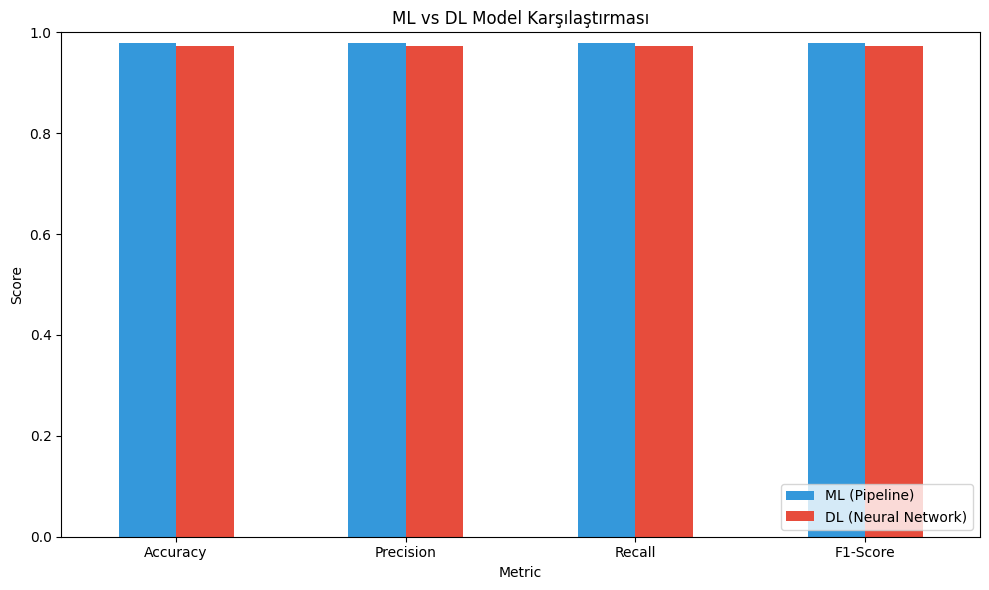


🏆 Sonuç: ML modeli F1-Score bazında daha iyi performans göstermiştir.


In [14]:
# ML vs DL Comparison
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ML Predictions
ml_pred = ml_pipeline.predict(X_test)
ml_acc = accuracy_score(y_test, ml_pred)
ml_prec = precision_score(y_test, ml_pred, average='weighted')
ml_rec = recall_score(y_test, ml_pred, average='weighted')
ml_f1 = f1_score(y_test, ml_pred, average='weighted')

# DL Predictions
dl_pred_prob = model.predict(X_test_vec, verbose=0)
dl_pred = (dl_pred_prob > 0.5).astype(int).flatten()
dl_acc = accuracy_score(y_test, dl_pred)
dl_prec = precision_score(y_test, dl_pred, average='weighted')
dl_rec = recall_score(y_test, dl_pred, average='weighted')
dl_f1 = f1_score(y_test, dl_pred, average='weighted')

# Comparison Table
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'ML (Pipeline)': [ml_acc, ml_prec, ml_rec, ml_f1],
    'DL (Neural Network)': [dl_acc, dl_prec, dl_rec, dl_f1]
})
comparison_df = comparison_df.set_index('Metric')
display(comparison_df.style.format("{:.4f}").highlight_max(axis=1, color='lightgreen'))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
comparison_df.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'])
ax.set_title('ML vs DL Model Karşılaştırması')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.legend(loc='lower right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

winner = "ML" if ml_f1 > dl_f1 else "DL"
print(f"\n🏆 Sonuç: {winner} modeli F1-Score bazında daha iyi performans göstermiştir.")

In [15]:
# Evaluate DL Model
loss, accuracy = model.evaluate(X_test_vec, y_test)
print(f'DL Model Accuracy: {accuracy:.4f}')


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9722 - loss: 0.0996
DL Model Accuracy: 0.9722


In [16]:
"""
# Save Models
import traceback
import os
import pickle

# 1. Save ML Model
try:
    if 'cv' in locals() and 'clf' in locals():
        from sklearn.pipeline import Pipeline
        import joblib
        ml_pipeline = Pipeline([
            ('vectorizer', cv),
            ('classifier', clf)
        ])
        joblib.dump(ml_pipeline, 'models/best_model.pkl')
        print('✅ ML model saved as best_model.pkl')
    else:
        print('⚠️ ML model components (cv, clf) not found.')
except Exception as e:
    print(f'❌ Failed to save ML model: {e}')

# 2. Save DL Model & Vectorizer
try:
    # Save Vectorizer Vocabulary/Config for reconstruction
    # This is critical for loading the model correctly without the LookupTable bug
    if 'vectorizer' in locals():
        vocab = vectorizer.get_vocabulary()
        config = vectorizer.get_config()
        with open('vectorizer_vocab.pkl', 'wb') as f:
            pickle.dump({'vocab': vocab, 'config': config}, f)
        print('✅ Vectorizer config saved as vectorizer_vocab.pkl')
    else:
        print('⚠️ Vectorizer not found.')

    # Save Model as H5 (safer for this environment)
    if 'model' in locals():
        model.save('models/dl_model.h5')
        print('✅ DL model saved as dl_model.h5')
    else:
        print('⚠️ DL model not found.')
except Exception as e:
    print(f'❌ Failed to save DL model/vectorizer: {e}')
    traceback.print_exc()
"""

# Save Models for App
# 1. Save ML Model
joblib.dump(ml_pipeline, 'models/best_model.pkl')
print('ML Model saved as best_model.pkl')

# 2. Save DL Model (H5) & Vectorizer Vocab
model.save('models/dl_model.h5')

vocab = vectorizer.get_vocabulary()
config = vectorizer.get_config()
with open('models/vectorizer_vocab.pkl', 'wb') as f:
    pickle.dump({'vocab': vocab, 'config': config}, f)

print('DL Model saved as dl_model.h5')
print('Vectorizer vocab saved as vectorizer_vocab.pkl')

ML Model saved as best_model.pkl
DL Model saved as dl_model.h5
Vectorizer vocab saved as vectorizer_vocab.pkl


## Sonuç ve Değerlendirme

Bu proje, SMS spam tespiti için TF-IDF tabanlı SVM ve Embedding tabanlı derin öğrenme modellerini karşılaştırmıştır.

| Model | Doğruluk | Yaklaşım |
|-------|----------|----------|
| **SVM + TF-IDF (1-2 gram)** | **97.94%** | Geleneksel ML |
| Embedding + GAP + Dense | 97.22% | Derin Öğrenme |

**Temel Bulgular:**
- Her iki model de %97+ doğruluk elde etmiştir; SVM hafif üstündür
- TF-IDF + SVM kombinasyonu, seyrek metin verisinde oldukça etkilidir
- Spam mesajlar genellikle "free", "win", "prize", "call now" gibi anahtar kelimeler içerir
- Sınıf dengesizliği (ham: %87, spam: %13) modelin precision-recall dengesini etkiler
- Gerçek üretim ortamında False Negative (gözden kaçan spam) maliyeti yüksek olduğundan recall optimizasyonu önerilir